# Importing libraries

In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore 
from imblearn.over_sampling import SMOTE

# Uploading the data

In [66]:
#afficher les 5 premiére lignes
df=pd.read_csv("water_quality_classifier_mean_state.csv")
df.head(5)

,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,WQI clf
0,6.7,7.5,203.0,21.947222,0.1,11.0,27.0,0
1,5.7,7.2,189.0,2.000000,0.2,4953.0,8391.0,0
2,6.3,6.9,179.0,1.700000,0.1,3243.0,5330.0,0
3,5.8,6.9,64.0,3.800000,0.5,5382.0,8443.0,0
4,5.8,7.3,83.0,1.900000,0.4,3428.0,5500.0,0


In [67]:
#afficher la taille du dataframe (nb_lignes,nb_colonnes)
df.shape

(1670, 8)

In [68]:
df[df['WQI clf']==4]

,DO,PH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,WQI clf
1667,6.5,5.80,67.0,0.400,0.54,123.0,520.0,4
1668,6.1,3.10,738.0,5.500,2.73,32.0,45.0,4
1669,6.4,3.05,605.0,5.067,4.80,18.0,45.0,4


In [69]:
n_unsuitable=(df['WQI clf']==0).sum()
n_very_poor=(df['WQI clf']==1).sum()
n_poor=(df['WQI clf']==2).sum()
n_good=(df['WQI clf']==3).sum()
n_excellent=(df['WQI clf']==4).sum()

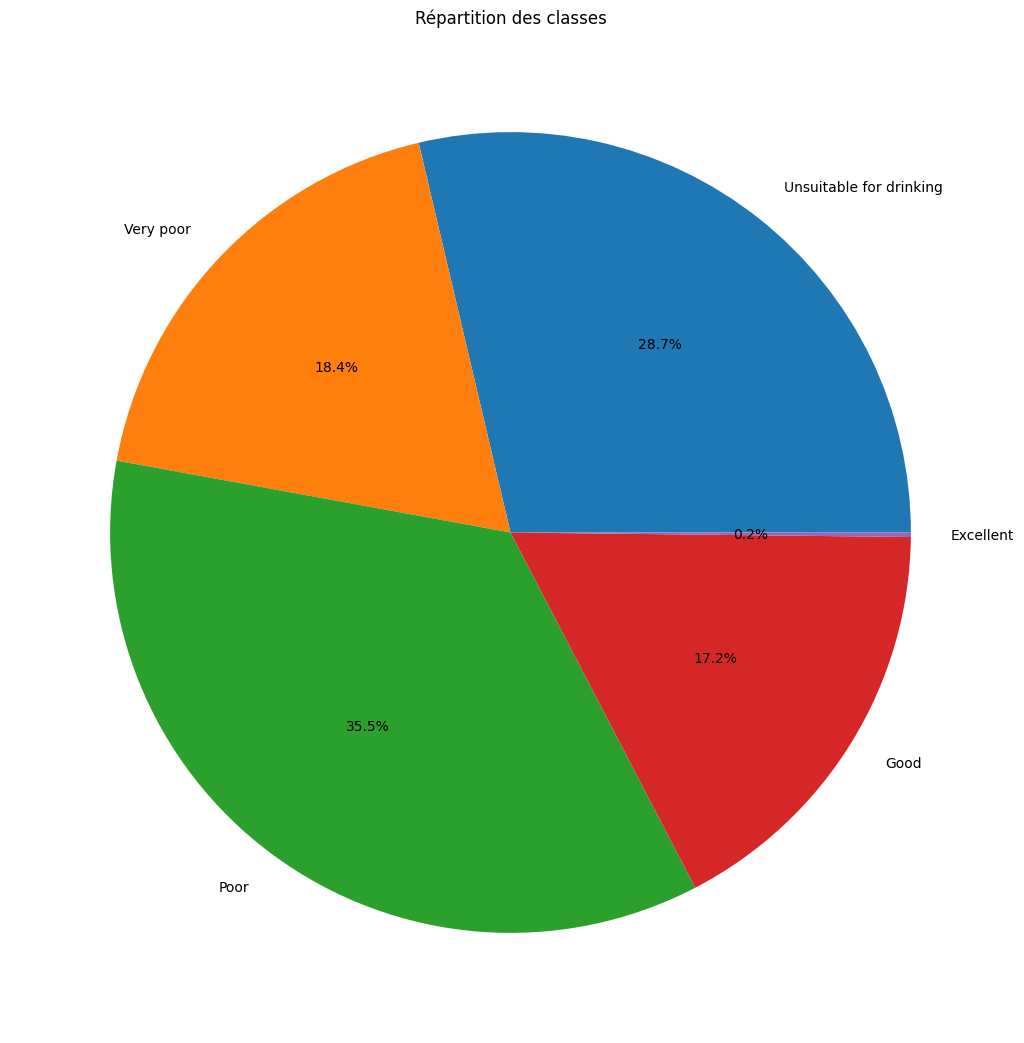

In [70]:
import matplotlib.pyplot as plt
# Définition des classes et de leurs effectifs
classes = ['Unsuitable for drinking', 'Very poor', 'Poor', 'Good', 'Excellent']
effectifs = [n_unsuitable,n_very_poor,n_poor,n_good,n_excellent]
# Création du diagramme circulaire
fig, ax = plt.subplots()
ax.pie(effectifs, labels=classes, autopct='%2.1f%%')
# Définir la taille de la figure
fig.set_size_inches(14, 13)
# Ajout d'un titre
ax.set_title('Répartition des classes')
# Affichage du diagramme
plt.show()


In [72]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,Dropout
from tensorflow.keras.utils import to_categorical

# Charger les données
data = df

In [73]:
cols_to_drop=["WQI clf"]
# Diviser les données en caractéristiques et cibles
X =  data.drop(cols_to_drop, axis=1)
y = data["WQI clf"].values

In [ ]:
# Encoder les labels catégoriels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Balancing the data by SMOTE - Oversampling of Minority level\n')
smt = SMOTE()
counter = Counter(y)
print('Before SMOTE', counter)
X,y = smt.fit_resample(X,y)
counter = Counter(y)
print('\nAfter SMOTE', counter)

Balancing the data by SMOTE - Oversampling of Minority level

Before SMOTE Counter({2: 593, 0: 479, 1: 308, 3: 287, 4: 12})

After SMOTE Counter({0: 593, 1: 593, 2: 593, 3: 593, 4: 593})


In [74]:
from sklearn.model_selection import train_test_split

# Assuming X is your input features and y is your target variable (array of classes)

# Splitting the data class by class
class_indices = range(5)  # Assuming y is a 1D array containing class labels

X_train, X_test, y_train, y_test = [], [], [], []

for i in class_indices:
    # Selecting the data for the current class
    X_class = X[y == i]
    y_class = y[y == i]
    
    # Splitting the data into training and testing sets
    X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
    
    # Appending the data for the current class to the respective lists
    X_train.append(X_class_train)
    X_test.append(X_class_test)
    y_train.append(y_class_train)
    y_test.append(y_class_test)

# Converting the lists to numpy arrays if needed
X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)
y_train = np.concatenate(y_train)
y_test = np.concatenate(y_test)


In [75]:
# Redimensionner les données pour les convolutions 1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [76]:
# Convertir les labels en one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Créer le modèle CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation="softmax"))

In [78]:
from sklearn.model_selection import KFold
# Définir les hyperparamètres pour la validation croisée
kfold = KFold(n_splits=5, shuffle=True)
for train_indices, val_indices in kfold.split(X_train):
    # Séparer les données d'entraînement et de validation pour chaque fold
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]

    # Compiler le modèle
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entraîner le modèle sur les données d'entraînement du fold actuel
    history = model.fit(X_train_fold, y_train_fold,validation_data=(X_val_fold,y_val_fold), batch_size=32, epochs=100, verbose=1)

    # Évaluer le modèle sur les données de validation du fold actuel
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)

    # Afficher les résultats de chaque fold
    print("Validation loss: {:.4f}, Validation accuracy: {:.4f}".format(val_loss, val_acc))

Epoch 1/100
34/34 [==============================] - 1s 12ms/step - loss: 1.2225 - accuracy: 0.5117 - val_loss: 1.2550 - val_accuracy: 0.5356
Epoch 2/100
34/34 [==============================] - 0s 8ms/step - loss: 1.1727 - accuracy: 0.5230 - val_loss: 1.0683 - val_accuracy: 0.5843
Epoch 3/100
34/34 [==============================] - 0s 7ms/step - loss: 1.0347 - accuracy: 0.5586 - val_loss: 1.0278 - val_accuracy: 0.5655
Epoch 4/100
34/34 [==============================] - 0s 7ms/step - loss: 1.0349 - accuracy: 0.5679 - val_loss: 1.1293 - val_accuracy: 0.5431
Epoch 5/100
34/34 [==============================] - 0s 7ms/step - loss: 1.0869 - accuracy: 0.5501 - val_loss: 1.1707 - val_accuracy: 0.5693
Epoch 6/100
34/34 [==============================] - 0s 12ms/step - loss: 1.0392 - accuracy: 0.5623 - val_loss: 1.0200 - val_accuracy: 0.6404
Epoch 7/100
34/34 [==============================] - 0s 11ms/step - loss: 0.9860 - accuracy: 0.5829 - val_loss: 0.9434 - val_accuracy: 0.6367
Epoch 8/10

In [79]:
# Évaluer le modèle sur les données de test
score = model.evaluate(X_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

11/11 [==============================] - 0s 2ms/step - loss: 1.5157 - accuracy: 0.8304
Test loss: 1.515723705291748
Test accuracy: 0.8303571343421936


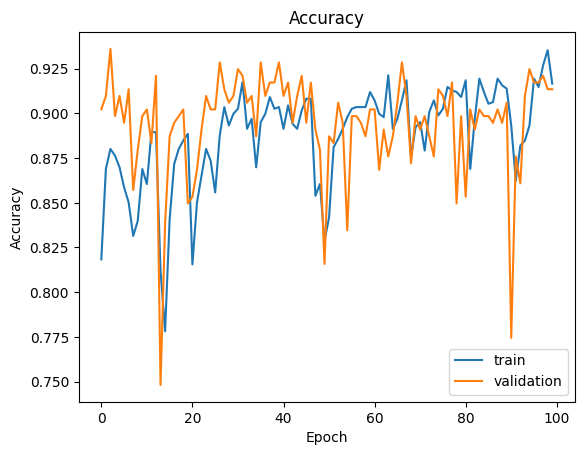

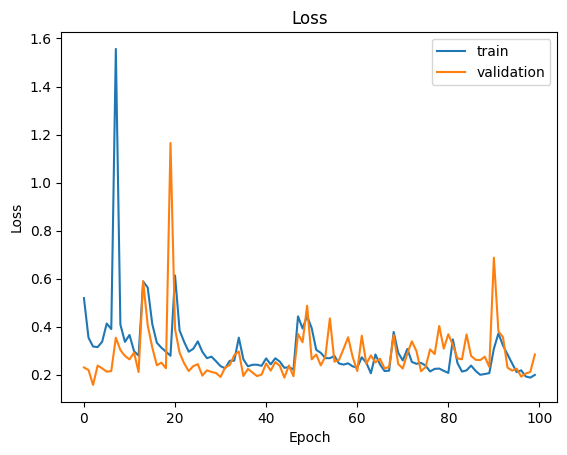

In [80]:
# Afficher les graphes d'accuracy et loss selon l'epoch
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [81]:
y_pred_cnn = model.predict(X_test)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

11/11 [==============================] - 0s 2ms/step


In [82]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_cnn)

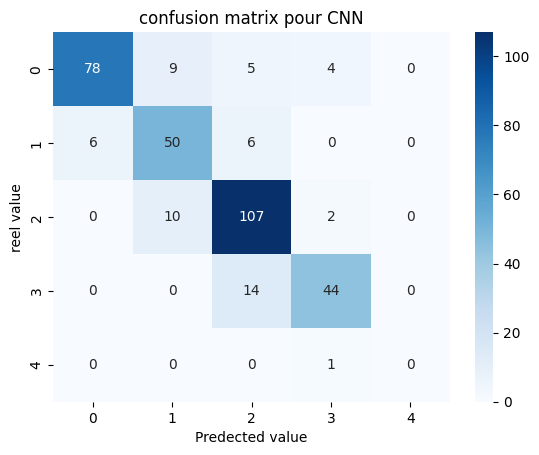

In [83]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(np.argmax(y_test, axis=1),y_pred_cnn)
# Visualiser la matrice de confusion avec seaborn
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('confusion matrix pour CNN')
plt.xlabel('Predected value')
plt.ylabel('reel value')
plt.show()


In [84]:
print ("Classification Report")
print(classification_report(np.argmax(y_test, axis=1),y_pred_cnn))

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        96
           1       0.72      0.81      0.76        62
           2       0.81      0.90      0.85       119
           3       0.86      0.76      0.81        58
           4       0.00      0.00      0.00         1

    accuracy                           0.83       336
   macro avg       0.67      0.66      0.66       336
weighted avg       0.84      0.83      0.83       336



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


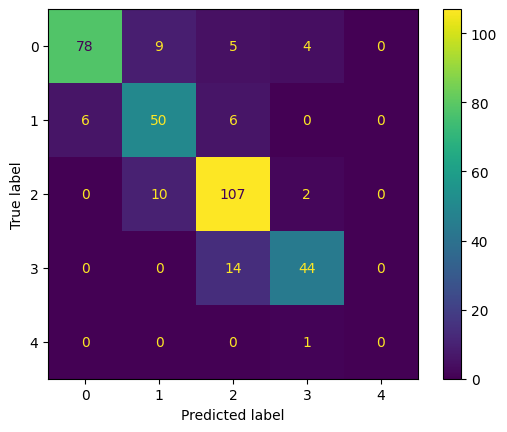

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()